***
# Classification And Clustering Of Weather Events
## by Dominik Knabe
***

***
## Application Domain 
- Climate change leads to severe changes in weather patterns and events 
- Frequency and intensity of droughts will increase in future (Parry et al., 2007)
--> Far reaching impacts on ecosystems, water supplies, agricultural production, human health, energy costs, critical 
    infrastructure and local economies (10.3133/cir1430)
- Number of major hurricanes has increased due to higher sea surface temperatures (https://doi.org/10.1073/pnas.1920849117)

***

***
## Application Domain II 
### 1980 - Today:
- 355 weather/climate desasters in U.S.
- 2,541.1B Dollar damage (57.8B per year)
- 15955 deaths
- ncei.noaa.gov 
***

***
## Dataset
- Storm Events Database (https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/)
- Used data from 2015 - 2023
- Contains information about storm and other significant weather events that could cause damage to 
  property/crops or human health
- 503411 observations
***

***
## Research Goal 
- Can significant weather events be classified based on location, duration, month, financial and human health damage.
  --> Random Forest Classifier
- Do correctly classified events cluster across the study area 
  --> Local Moran's I
***

***
# Data Import
***

In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import seaborn as sns
import esda
import libpysal as lps
import pysal
from IPython.display import display
from esda.moran import Moran
from esda.moran import Moran_Local
from Functions import ind_VfoldCross
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import SilhouetteVisualizer
from matplotlib import gridspec
from matplotlib.cm import get_cmap
from libpysal.weights import Queen
import warnings
warnings.filterwarnings("ignore")



C:\Users\domik\anaconda3\envs\gpaSS\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\domik\AppData\Local\Temp\ipykernel_1720\39239016.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedoc

In [2]:
# load data and rename columns 
df=pd.read_csv(r'C:\Studium\SS23\PS_Geograpical_Predictive_Analysis\Abschlussprojekt_GPA\Daten\Storm_Dataset.csv', sep=";",index_col=False,header=0,skiprows=0,)
df=df[['BEGIN_YEARMONTH','END_YEARMONTH','STATE','EVENT_TYPE','BEGIN_DATE_TIME','END_DATE_TIME','INJURIES_DIRECT','INJURIES_INDIRECT','DEATHS_DIRECT','DEATHS_INDIRECT','DAMAGE_PROPERTY','DAMAGE_CROPS','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON']]

new_names = {'BEGIN_YEARMONTH': 'YRMO_A', 'BEGIN_DAY': 'DAY_A', 'BEGIN_TIME': 'TIME_A',
    'END_YEARMONTH': 'YRMO_B', 'END_DAY': 'DAY_B','END_TIME': 'TIME_B',
    'STATE': 'STATE', 'INJURIES_DIRECT' : 'INJ_DIR',
    'INJURIES_INDIRECT' : 'INJ_INDIR', 'DEATHS_DIRECT' : 'DEATHS_DIR',
    'DEATHS_INDIRECT' : 'DEATHS_INDIR','DAMAGE_PROPERTY' : 'DMG_PROP',
    'DAMAGE_CROPS' : 'DMG_CRP', 'BEGIN_LAT' : 'LAT_A',
    'BEGIN_LON' : 'LON_A', 'END_LAT' : 'LAT_B',
    'END_LON' : 'LON_B'}

df.rename(columns=new_names, inplace=True)


In [3]:
print(df.shape)
df.head()

(503411, 16)


YRMO_A  YRMO_B     STATE      EVENT_TYPE   BEGIN_DATE_TIME   
0  202301  202301   ALABAMA         Tornado  12.01.2023 10:47  \
1  202301  202301   MONTANA       Dense Fog  11.01.2023 03:55   
2  202301  202301   MONTANA       Dense Fog  11.01.2023 05:10   
3  202301  202301  ILLINOIS         Tornado  03.01.2023 16:33   
4  202301  202301  MISSOURI  Winter Weather  29.01.2023 02:00   

      END_DATE_TIME  INJ_DIR  INJ_INDIR  DEATHS_DIR  DEATHS_INDIR DMG_PROP   
0  12.01.2023 11:10        0          0           0             0    0.00K  \
1  12.01.2023 06:35        0          0           0             0    0.00K   
2  12.01.2023 04:55        0          0           0             0    0.00K   
3  03.01.2023 16:34        0          0           0             0    0.00K   
4  30.01.2023 02:00        0          0           0             0      NaN   

  DMG_CRP     LAT_A     LON_A     LAT_B     LON_B  
0   0.00K  326221.0 -877543.0   32723.0  -87474.0  
1   0.00K       NaN       NaN       NaN       NaN  
2   0.00K       NaN       NaN       NaN       NaN  
3   0.00K  400109.0 -890144.0  400136.0 -890096.0  
4     NaN       NaN       NaN       NaN       NaN

***
## EDA and Data Preprocessing 
***

In [4]:
#Delete rows that contain NaN
df=df.dropna()


In [5]:
#seperate YRMO (e.g.202003 --> 2020 & 03)
df['YRMO_A'] = df['YRMO_A'].astype(str)
df['YRMO_B'] = df['YRMO_B'].astype(str)

df['YR_A'] = df['YRMO_A'].str[0:4]
df['MO_A'] = df['YRMO_A'].str[4:6]

df['YR_B'] = df['YRMO_B'].str[0:4]
df['MO_B'] = df['YRMO_B'].str[4:6]

df.drop('YRMO_A', axis=1, inplace=True)
df.drop('YRMO_B', axis=1, inplace=True)

In [6]:
#Convert DMG to float (e.g. 50K --> 50000)
#cut last letter of DMG
df['DMG_PROP'] = df['DMG_PROP'].str[:-1]
df['DMG_CRP'] = df['DMG_CRP'].str[:-1]

df['DMG_PROP'] = df['DMG_PROP'].astype(float)*1000
df['DMG_CRP'] = df['DMG_CRP'].astype(float)*1000

In [7]:
#Adjust coordinates (e.g. 375621 --> 37.5621)
df['LAT_A']=df['LAT_A']*0.0001
df['LAT_B']=df['LAT_B']*0.0001
df['LON_A']=df['LON_A']*0.0001
df['LON_B']=df['LON_B']*0.0001


In [8]:
#calculate duration of event 
df['BEGIN_DATE_TIME'] = pd.to_datetime(df['BEGIN_DATE_TIME'], format='%d.%m.%Y %H:%M')
df['END_DATE_TIME'] = pd.to_datetime(df['END_DATE_TIME'], format='%d.%m.%Y %H:%M')
df['DURATION_HR'] = (df['END_DATE_TIME'] - df['BEGIN_DATE_TIME']).dt.total_seconds() / 3600
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df['LON_B'], df['LAT_B']))
gdf = gdf.drop(['BEGIN_DATE_TIME','END_DATE_TIME','YR_A','YR_B'], axis=1)


<IPython.core.display.Javascript object>


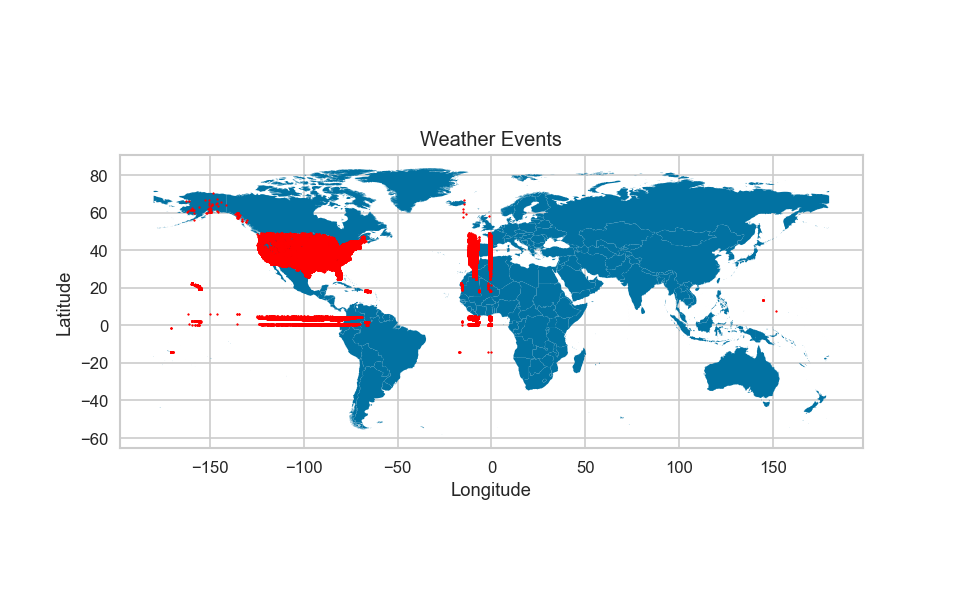

In [9]:
%matplotlib notebook
#Plot observations and world map
geojson_file = 'C:\Studium\SS23\PS_Geograpical_Predictive_Analysis\Abschlussprojekt_GPA\Daten\world-administrative-boundaries.geojson'
basemap = gp.read_file(geojson_file)

basemap.plot(figsize=(8,5))
gdf.plot(ax=plt.gca(), marker='o', color='red', markersize=1)
plt.title('Weather Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<IPython.core.display.Javascript object>


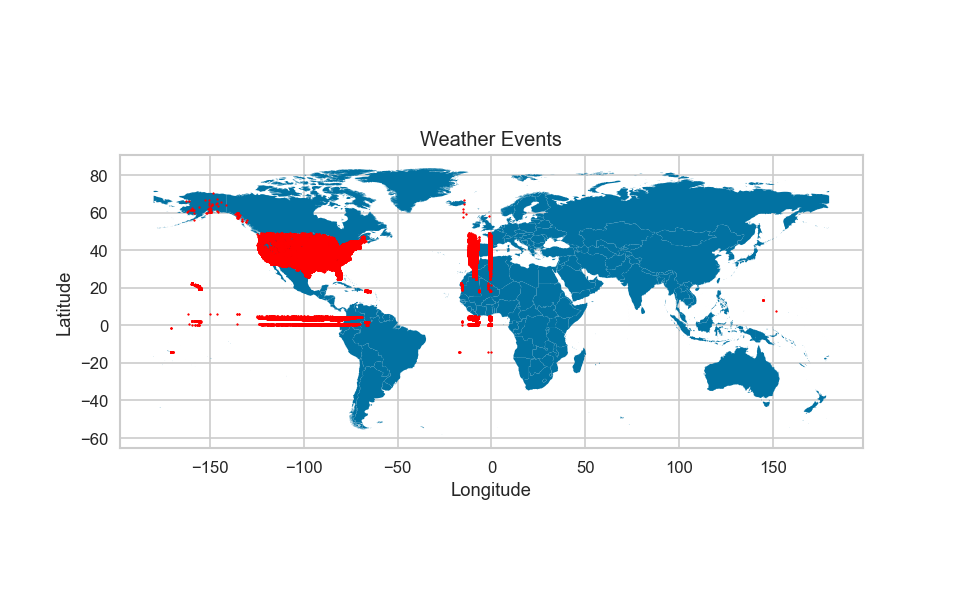

In [10]:
display(plt.gcf())  

In [11]:
#Crop samples to the extent of the USA
gdf = gdf[(gdf['LON_B'] >= -170) & (gdf['LON_B'] <= -60)]
gdf = gdf[(gdf['LAT_B'] <= 75) & (gdf['LAT_B'] >= 20)]
gdf = gdf.drop(['LAT_A','LON_A','LAT_B','LON_B'], axis=1)

<IPython.core.display.Javascript object>


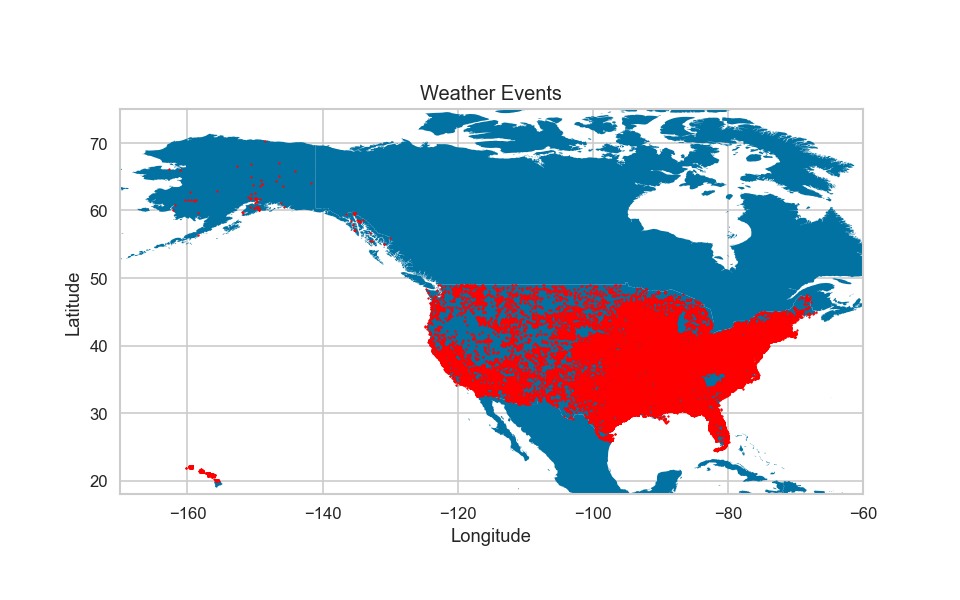

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
basemap.plot(ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=1)

ax.set_xlim(-170, -60)
ax.set_ylim(18, 75 )
plt.title('Weather Events'); plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

<IPython.core.display.Javascript object>


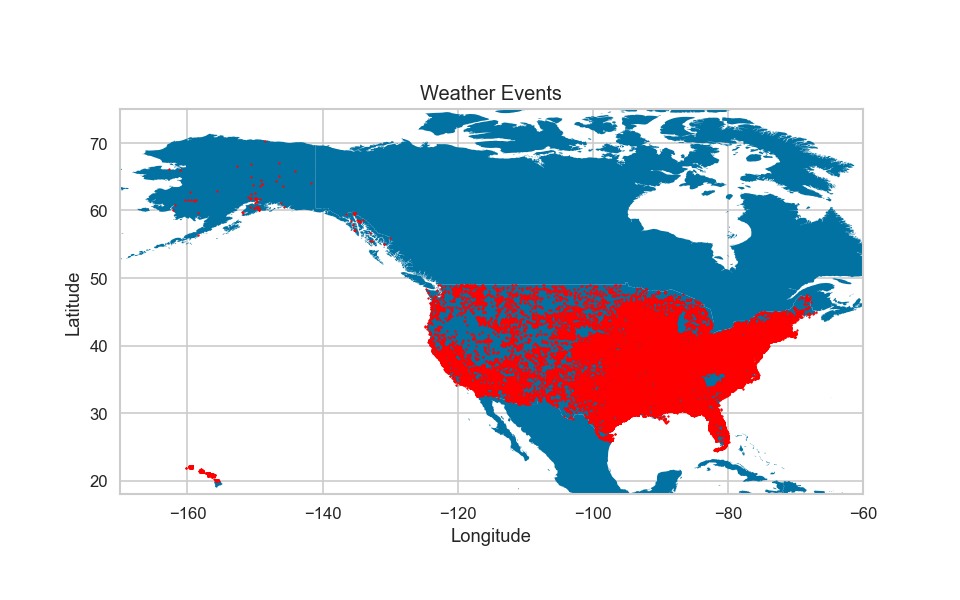

In [13]:
display(plt.gcf())

<IPython.core.display.Javascript object>


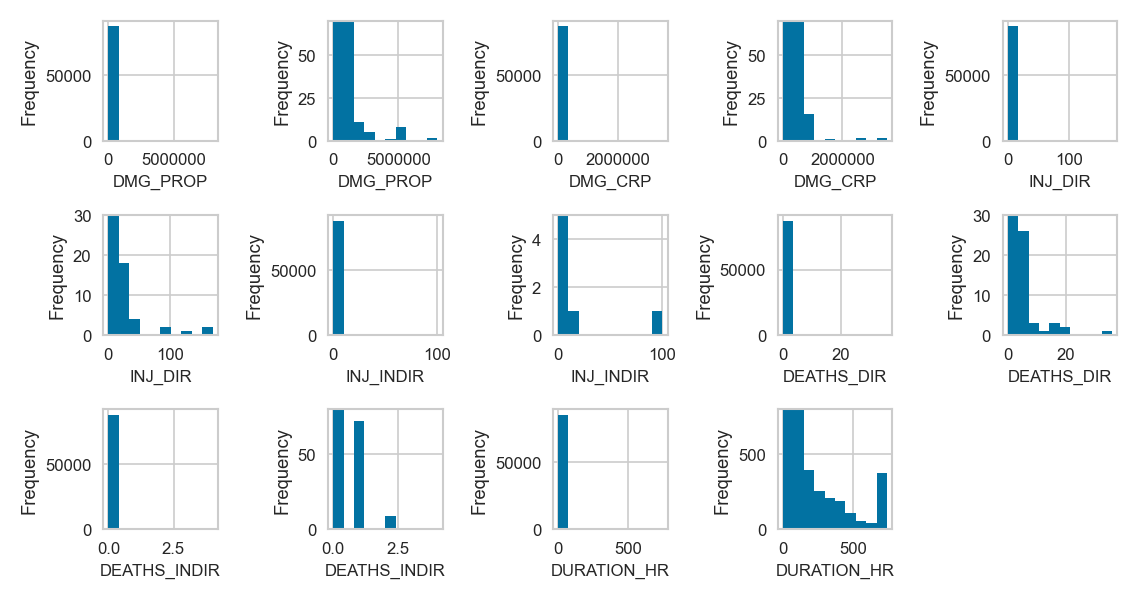

In [14]:
# Creating histograms for my independent variables

dmg_prop = gdf['DMG_PROP']
dmg_crp = gdf['DMG_CRP']
deaths_dir=gdf['DEATHS_DIR']
deaths_indir=gdf['DEATHS_INDIR']
inj_dir=gdf['INJ_DIR']
inj_indir=gdf['INJ_INDIR']
state=gdf['STATE']
mo_b=gdf['MO_B']
duration_hr=gdf['DURATION_HR']
event_type=gdf['EVENT_TYPE']


# Create DMG_PROP
fig, axes = plt.subplots(3, 5, figsize=(9.5, 5))
axes=axes.flatten()

axes[0].hist(dmg_prop, bins=10)

axes[0].set_xlabel('DMG_PROP',fontsize=10)
axes[0].set_ylabel('Frequency')
axes[0].ticklabel_format(style='plain', axis='x')

# Create DMG_PROP smaller ylim
axes[1].hist(dmg_prop, bins=10)

axes[1].set_xlabel('DMG_PROP',fontsize=10)
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0,70)
axes[1].ticklabel_format(style='plain', axis='x')

#DMG_CRP
axes[2].hist(dmg_crp, bins=10)

axes[2].set_xlabel('DMG_CRP',fontsize=10)
axes[2].set_ylabel('Frequency')
axes[2].ticklabel_format(style='plain', axis='x')

# DMG_CRP smaller ylim
axes[3].hist(dmg_crp, bins=10)

axes[3].set_xlabel('DMG_CRP',fontsize=10)
axes[3].set_ylabel('Frequency')
axes[3].set_ylim(0,70)
axes[3].ticklabel_format(style='plain', axis='x')

#INJ_DIR 
axes[4].hist(inj_dir, bins=10)

axes[4].set_xlabel('INJ_DIR',fontsize=10)
axes[4].set_ylabel('Frequency')

#INJ_DIR smaller ylim
axes[5].hist(inj_dir, bins=10)

axes[5].set_xlabel('INJ_DIR',fontsize=10)
axes[5].set_ylabel('Frequency')
axes[5].set_ylim(0,30)

#INJ_INDIR
axes[6].hist(inj_indir, bins=10)

axes[6].set_xlabel('INJ_INDIR',fontsize=10)
axes[6].set_ylabel('Frequency')

#INJ_INDIR smaller ylim
axes[7].hist(inj_indir, bins=10)

axes[7].set_xlabel('INJ_INDIR',fontsize=10)
axes[7].set_ylabel('Frequency')
axes[7].set_ylim(0,5)

#DEATHS_DIR
axes[8].hist(deaths_dir, bins=10)

axes[8].set_xlabel('DEATHS_DIR',fontsize=10)
axes[8].set_ylabel('Frequency')

#DEATHS_DIR smaller ylim
axes[9].hist(deaths_dir, bins=10)

axes[9].set_xlabel('DEATHS_DIR',fontsize=10)
axes[9].set_ylabel('Frequency')
axes[9].set_ylim(0,30)

#DEATHS_INDIR
axes[10].hist(deaths_indir, bins=10)

axes[10].set_xlabel('DEATHS_INDIR',fontsize=10)
axes[10].set_ylabel('Frequency')

#DEATHS_INDIR smaller ylim
axes[11].hist(deaths_indir, bins=10)

axes[11].set_xlabel('DEATHS_INDIR',fontsize=10)
axes[11].set_ylabel('Frequency')
axes[11].set_ylim(0,80)

#duration
axes[12].hist(duration_hr, bins=10)

axes[12].set_xlabel('DURATION_HR',fontsize=10)
axes[12].set_ylabel('Frequency')

#duration smaller xlim
axes[13].hist(duration_hr, bins=10)

axes[13].set_xlabel('DURATION_HR',fontsize=10)
axes[13].set_ylabel('Frequency')
axes[13].set_ylim(0,800)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


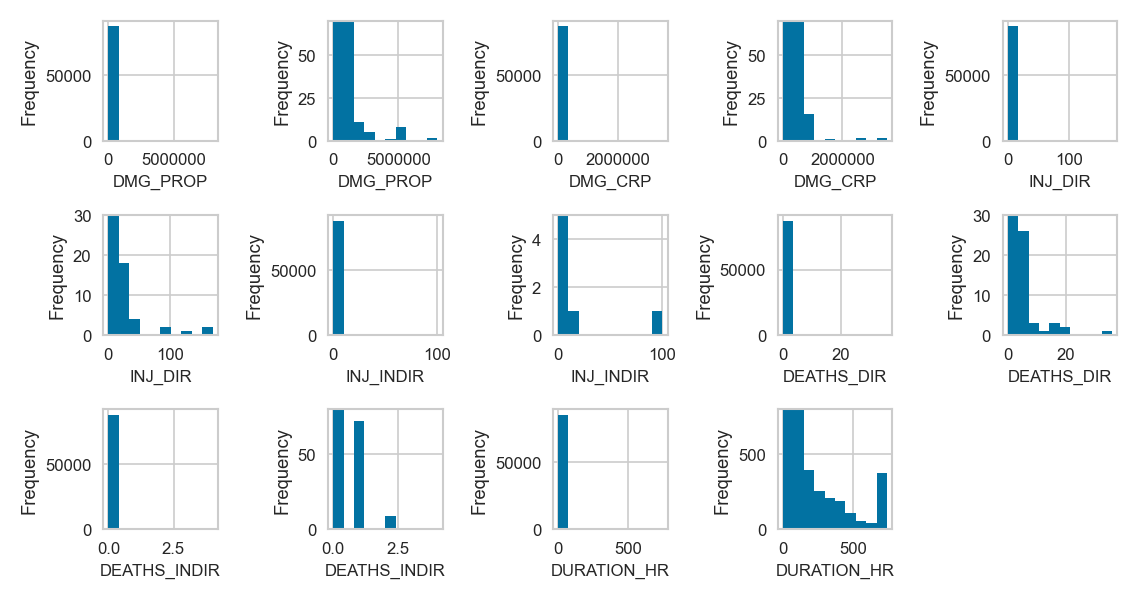

In [15]:
display(plt.gcf())

<IPython.core.display.Javascript object>


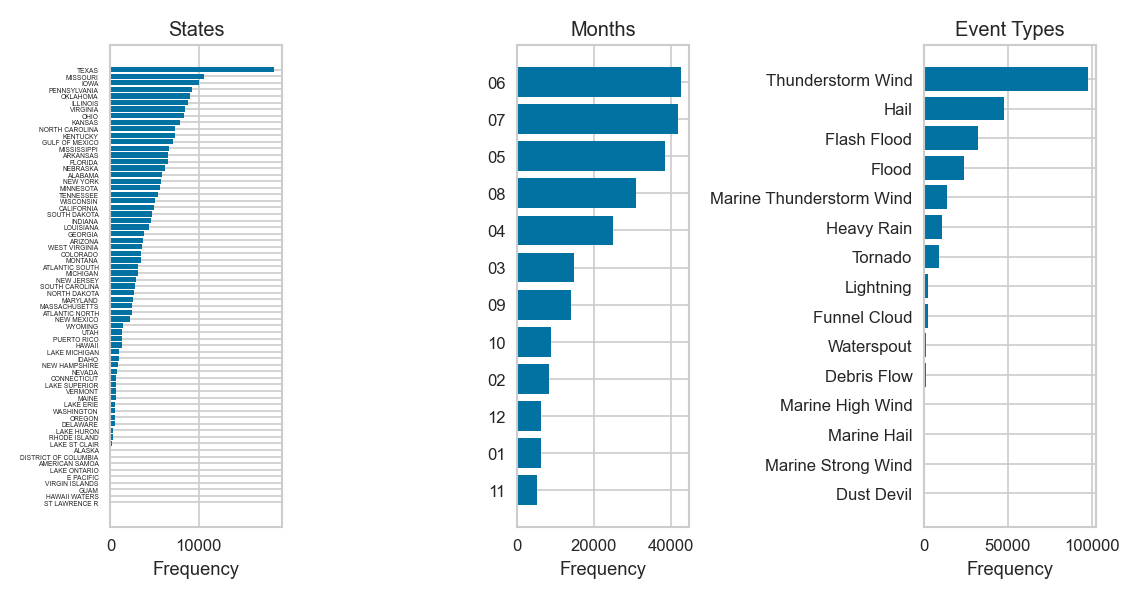

In [16]:
#count how often each state is represented in df['STATE']
state_counts = df['STATE'].value_counts()
#sort states 
state_counts = state_counts.sort_values(ascending=True)

#count how often each month is represented in df['MO_B']
mo_counts = df['MO_B'].value_counts()
#sort months 
mo_counts = mo_counts.sort_values(ascending=True)

#count how often each event type is represented in df['EVENT_TYPE']
type_counts = df['EVENT_TYPE'].value_counts()
#sort types 
type_counts = type_counts.sort_values(ascending=True)

#Plot
#count states
fig, axes = plt.subplots(1, 3, figsize=(9.5, 5))

axes = axes.flatten()

axes[0].barh(state_counts.index, state_counts, align='center')

axes[0].set_xlabel('Frequency')
axes[0].set_title('States')
axes[0].tick_params(axis='y', labelsize=4)

#count month
axes[1].barh(mo_counts.index, mo_counts, align='center')

axes[1].set_xlabel('Frequency')
axes[1].set_title('Months')

#count Eventtypes
axes[2].barh(type_counts.index, type_counts, align='center')

axes[2].set_xlabel('Frequency')
axes[2].set_title('Event Types')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


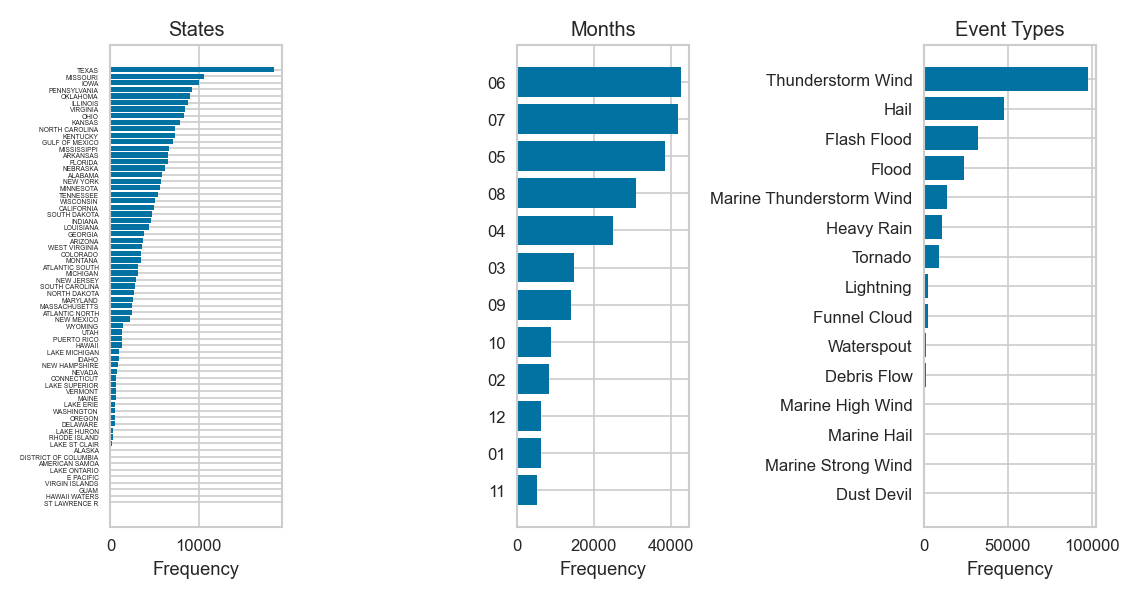

In [17]:
display(plt.gcf())

***
## Results EDA
- Distributions of numerical independent variables are very narrow
  --> most of the data has values close to zero 
- Numerical attributes vary in value range --> perform Normalization 
- Target values (classes) occur in different size (most events are Thunderstorm Winds) --> Balance train data
  --> makes the Accuracy worse but the model will be more 'honest' due to giving equal weight to each class
- Some labled attribute values like location and event type are too sparse to perfrom split into train and test data 
***

Identify values in 'STATE'/'EVENT_TYPE' that are too sparse to perform the split into train and test data (min 800 samples). 
Labeled data needs to appear in both datasets (train and test).

In [18]:
class_counts = gdf['STATE'].value_counts()
# Select classes that appear at least 800 times in gdf
selected_classes = class_counts[class_counts >= 800].index.tolist()
# Keep rows with filtered classes
gdf = gdf[gdf['STATE'].isin(selected_classes)]

class_counts = gdf['EVENT_TYPE'].value_counts()
selected_classes = class_counts[class_counts >= 800].index.tolist()
gdf = gdf[gdf['EVENT_TYPE'].isin(selected_classes)]
print(gdf.shape)

(78174, 12)


In [19]:
# Reshape attribute to array as required by scaler
dmg_crp = gdf['DMG_CRP'].values.reshape(-1, 1)
dmg_prop = gdf['DMG_PROP'].values.reshape(-1, 1)
deaths_dir = gdf['DEATHS_DIR'].values.reshape(-1, 1)
deaths_indir = gdf['DEATHS_INDIR'].values.reshape(-1, 1)
inj_dir= gdf['INJ_DIR'].values.reshape(-1, 1)
inj_indir= gdf['INJ_INDIR'].values.reshape(-1, 1)
duration_hr= gdf['DURATION_HR'].values.reshape(-1, 1)

Normalize numerical attributes leads to equal weighting of Classifier input attributes and better comparison of the attribute values. 

In [20]:
scaler = MinMaxScaler()

# Normalization
normalized_dmg_crp = scaler.fit_transform(dmg_crp)
normalized_dmg_prop = scaler.fit_transform(dmg_prop)
normalized_deaths_dir = scaler.fit_transform(deaths_dir)
normalized_deaths_indir = scaler.fit_transform(deaths_indir)
normalized_inj_dir = scaler.fit_transform(inj_dir)
normalized_inj_indir = scaler.fit_transform(inj_indir)
normalized_duration_hr = scaler.fit_transform(duration_hr)

In [ ]:
gdf['DMG_CRP'] = normalized_dmg_crp
gdf['DMG_PROP'] = normalized_dmg_prop
gdf['DEATHS_DIR'] = normalized_deaths_dir
gdf['DEATHS_INDIR'] = normalized_deaths_indir
gdf['INJ_DIR'] = normalized_inj_dir
gdf['INJ_INDIR'] = normalized_inj_indir
gdf['DURATION_HR'] = normalized_duration_hr

In [21]:
print(gdf.shape)
gdf.describe()

(78174, 12)


INJ_DIR     INJ_INDIR    DEATHS_DIR  DEATHS_INDIR      DMG_PROP   
count  78174.000000  78174.000000  78174.000000  78174.000000  78174.000000  \
mean       0.000176      0.000027      0.000321      0.000341      0.001950   
std        0.006019      0.003624      0.006473      0.012036      0.011297   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000375   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            DMG_CRP   DURATION_HR  
count  78174.000000  78174.000000  
mean       0.000400      0.015578  
std        0.008738      0.085736  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000291  
75%        0.000000      0.003472  
max        1.000000      1.000000

In [22]:
print(gdf.shape)
gdf.head()

(78174, 12)


STATE   EVENT_TYPE  INJ_DIR  INJ_INDIR  DEATHS_DIR  DEATHS_INDIR   
3   ILLINOIS      Tornado      0.0        0.0         0.0           0.0  \
10   ALABAMA  Flash Flood      0.0        0.0         0.0           0.0   
14   ALABAMA         Hail      0.0        0.0         0.0           0.0   
16   ALABAMA      Tornado      0.0        0.0         0.0           0.0   
19   ALABAMA      Tornado      0.0        0.0         0.0           0.0   

    DMG_PROP  DMG_CRP MO_A MO_B  DURATION_HR                    geometry  
3        0.0      0.0   01   01     0.000022  POINT (-89.00960 40.01360)  
10       0.0      0.0   01   01     0.002352  POINT (-86.38920 33.70270)  
14       0.0      0.0   01   01     0.000022  POINT (-85.95960 32.84410)  
16       0.0      0.0   01   01     0.000045  POINT (-85.43510 32.42970)  
19       0.0      0.0   01   01     0.000045  POINT (-85.91750 32.39070)

***
# Random Forest Classification
- Library: Scikit-Learn
- suitable for classification of labled data
- reduced overfitting by combining multiple decision trees 
- I initially chose RFC before I decided to balance my train data because it is good at handling imbalanced data itself
***

Split data and balance train data to make modell more "honest". Balancing will make the Accuracy worse but the model is more "honest".

In [23]:
#Split data into train and test data
train=gdf.sample(frac=0.75,random_state=300)
test=gdf.drop(train.index)

#balance the train data (300 samples per class). 
list_of_train = ind_VfoldCross(train['EVENT_TYPE'], 300)

#split independent variables (X) and target variable (y)
X_train_geom = train.drop('EVENT_TYPE', axis=1)
y_train = train['EVENT_TYPE']

#iloc selects the rows in X_train y_train with the specific indices from list_of_train
X_train_geom=X_train_geom.iloc[list_of_train,:]
y_train=y_train.iloc[list_of_train]
X_train=X_train_geom.drop('geometry', axis=1)

In [24]:
print(X_train.head())
print(y_train.head())

                 STATE  INJ_DIR  INJ_INDIR  DEATHS_DIR  DEATHS_INDIR   
55541         ILLINOIS      0.0        0.0         0.0           0.0  \
109653        MISSOURI      0.0        0.0         0.0           0.0   
484078  SOUTH CAROLINA      0.0        0.0         0.0           0.0   
371761          KANSAS      0.0        0.0         0.0           0.0   
315922            OHIO      0.0        0.0         0.0           0.0   

        DMG_PROP  DMG_CRP MO_A MO_B  DURATION_HR  
55541   0.000000      0.0   07   07     0.004032  
109653  0.000000      0.0   03   03     0.004839  
484078  0.007500      0.0   10   10     0.004144  
371761  0.000000      0.0   08   08     0.004032  
315922  0.000125      0.0   06   06     0.002688  
55541     Flash Flood
109653    Flash Flood
484078    Flash Flood
371761    Flash Flood
315922    Flash Flood
Name: EVENT_TYPE, dtype: object


In [25]:
X_test_geom = test.drop('EVENT_TYPE',axis=1)
X_test=X_test_geom.drop('geometry',axis=1)
y_test = test['EVENT_TYPE']

Encode the labled attribute state to numerical categorical values so it can be processed by RFC

In [26]:
#from sklearn.preprocessing
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the 'STATE' attribute
label_encoder.fit(X_train['STATE'])

X_train['STATE'] = label_encoder.transform(X_train['STATE'])
X_test['STATE'] = label_encoder.transform(X_test['STATE'])

***
## Cross Validation and Grid Search 
- Library: Scikit-Learn
- Cross Validation evaluates model performance on multiple subsets of the data and for four different numbers of 
  estimators.
- Grid Search finds the parameter that delivered the best Accuracy of the model
***

In [27]:
# cross-validation and grid search
n_estm_rng = [10, 50, 100, 200]
param_grid = {'n_estimators': n_estm_rng}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"n_estimators: {params['n_estimators']}, Mean Accuracy: {mean_score}")

# Get the best n_estimators value
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Best n_estimators: {best_n_estimators}")

n_estimators: 10, Mean Accuracy: 0.6591666666666667
n_estimators: 50, Mean Accuracy: 0.6720833333333334
n_estimators: 100, Mean Accuracy: 0.6775
n_estimators: 200, Mean Accuracy: 0.6754166666666668
Best n_estimators: 100


In [28]:
# Train the RandomForestClassifier with the best n_estimators value
clfRF = RandomForestClassifier(n_estimators=best_n_estimators, bootstrap=True)
clfRF.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred = clfRF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("F1_weighted score:", f1_weighted)
print(f"Validation Accuracy: {accuracy}")

F1_weighted score: 0.6249257464140099
Validation Accuracy: 0.5930720425706099


In [29]:
#Add predicted and true labels to Classifier Input 
#transform numpy array to series
y_pred_series = pd.Series(y_pred, name='PREDICTED')

# add y_pred to input data
points_classified_list= list(zip(test.geometry, y_pred_series, test['EVENT_TYPE']))

# Create a new GeoDataFrame from the combined data
points_classified = gp.GeoDataFrame(points_classified_list, columns=['geometry', 'PREDICTED','EVENT_TYPE'])
points_classified['TRUE']=points_classified['EVENT_TYPE']
points_classified=points_classified.drop('EVENT_TYPE', axis=1)

***
## Feature Importance
- RFC algorithm has also stored the feature importances that tell the impact each independent variable has on the prediction.
  In this case the attribute STATE, DURATION_HR and DMG_PROP are the most important attributes.
***

In [47]:
#Importance of independent variables
imp_values = clfRF.feature_importances_

# Extract names of independent variables
var_names = X_train.columns

# Create a dictionary to store feature importance values with corresponding feature names
var_imp = dict(zip(var_names, imp_values))

In [46]:
# Print feature importances
for var, importance in var_imp.items():
    print(f"{var}: {importance}")

STATE: 0.3370825672800444
INJ_DIR: 0.01758677942424452
INJ_INDIR: 0.0030248973135559177
DEATHS_DIR: 0.009258486565689956
DEATHS_INDIR: 0.0006700905800247369
DMG_PROP: 0.1330355019984213
DMG_CRP: 0.012035288186500497
MO_A: 0.06282572895080324
MO_B: 0.060618398882564054
DURATION_HR: 0.3638622608181514


### Confusion Matrix 
This Matrix shows the true classes on the y-axis and the predicted classes on the x-axis. Numbers on the diagonal show the number of correctly predicted samples for each class. Numbers to the right and the left show wrongly predicted values. 

<IPython.core.display.Javascript object>


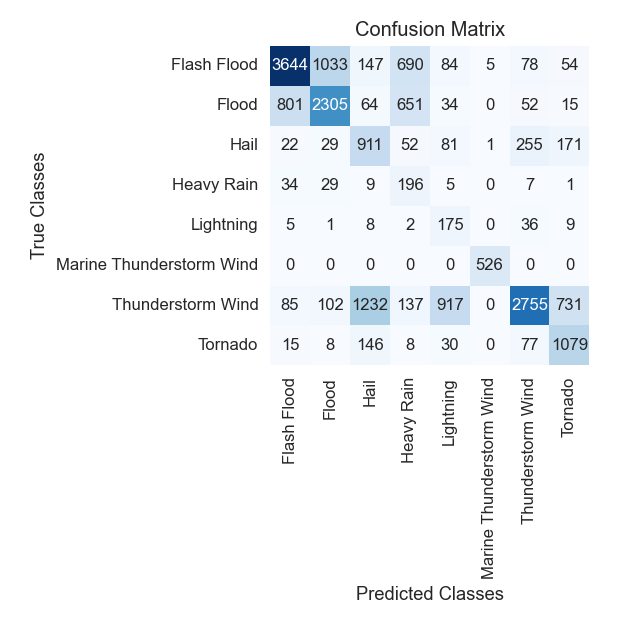

In [31]:
class_names = np.unique(np.concatenate((y_pred, y_test)))

# Determine the order of class names (e.g., sort alphabetically)
class_names = np.sort(class_names)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the number of classes
num_classes = len(class_names)

# Calculate the size of each cell
cell_size = 0.65  # Adjust the cell size as needed

# Calculate the figure size based on the number of classes and cell size
fig_width = cell_size * num_classes
fig_height = cell_size * num_classes

# Create a new figure with the calculated size
plt.figure(figsize=(fig_width, fig_height))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"fontsize": 10}, cbar=False, square=True)

plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


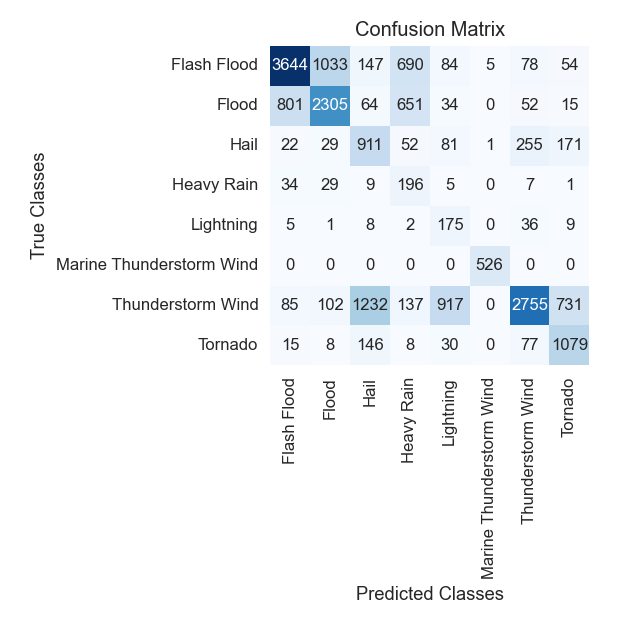

In [32]:
display(plt.gcf())

<IPython.core.display.Javascript object>


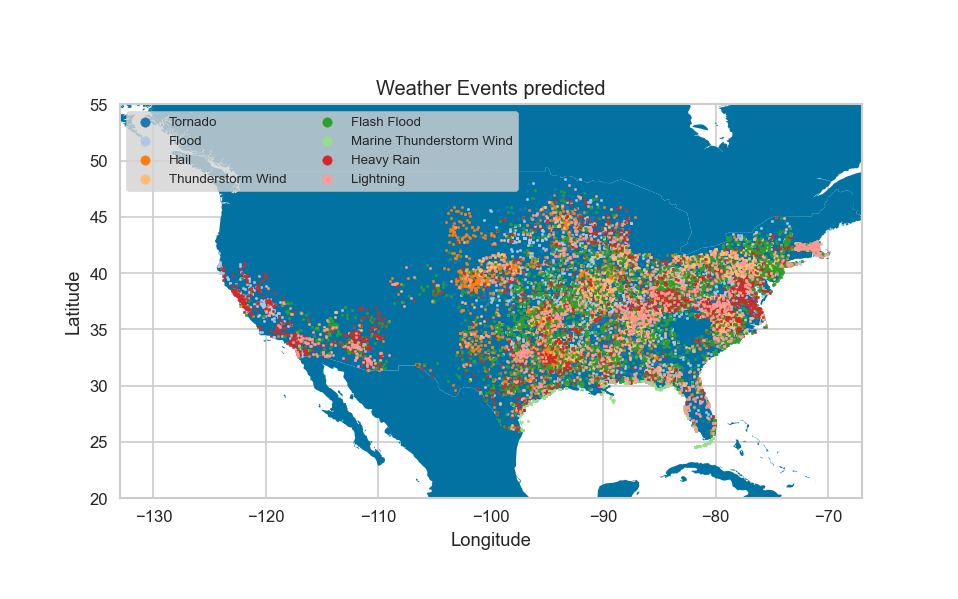

In [50]:
cmap = get_cmap('tab20')

# Get the unique classes in the 'class_column'
classes = points_classified['TRUE'].unique()

# Mapping each class a specific color
class_colors = {cls: cmap(i) for i, cls in enumerate(classes)}

fig, ax = plt.subplots(figsize=(8, 5))
basemap.plot(ax=ax)

# Plot points from points_classified with color coding
for class_name, color in class_colors.items():
    classes = points_classified[points_classified['PREDICTED'] == class_name]
    classes.plot(ax=ax, marker='o', color=color, markersize=2, label=class_name)

ax.set_xlim(-133, -67)
ax.set_ylim(20, 55)

legend = ax.legend(loc='upper left', markerscale=4, frameon=True, facecolor='lightgrey', ncol=2, fontsize=8)

plt.title('Weather Events predicted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

<IPython.core.display.Javascript object>


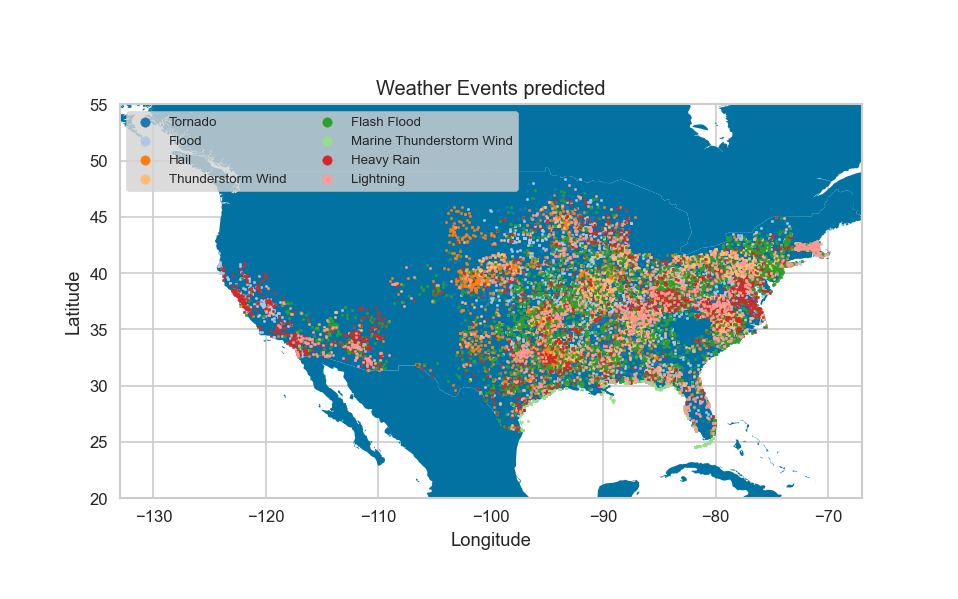

In [51]:
display(plt.gcf())

<IPython.core.display.Javascript object>


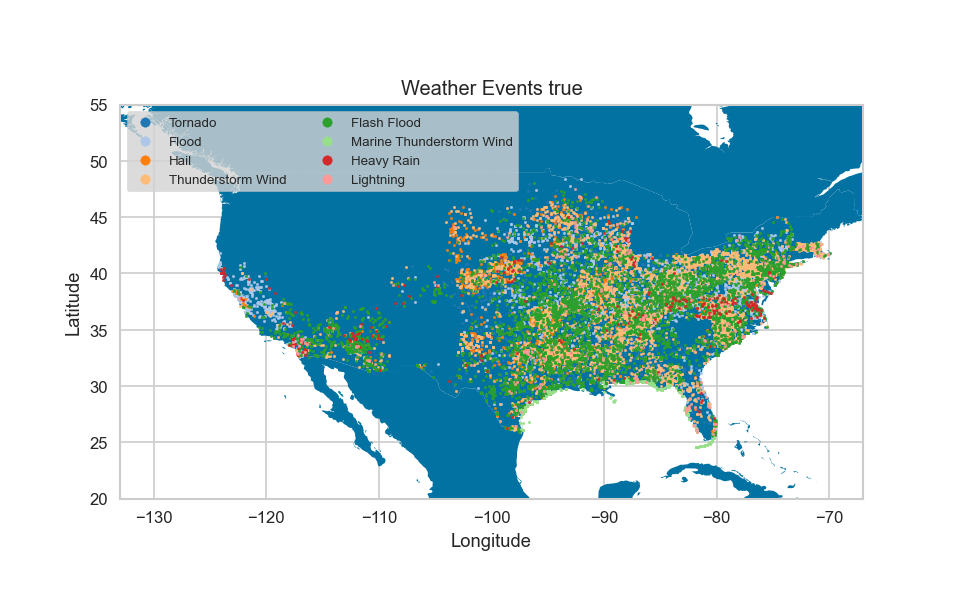

In [52]:
#Same method as in the plot before
cmap = get_cmap('tab20')

classes = points_classified['TRUE'].unique()

class_colors = {cls: cmap(i) for i, cls in enumerate(classes)}

fig, ax = plt.subplots(figsize=(8,5))
basemap.plot(ax=ax)

for class_name, color in class_colors.items():
    classes = points_classified[points_classified['TRUE'] == class_name]
    classes.plot(ax=ax, marker='o', color=color, markersize=2, label=class_name)

ax.set_xlim(-133, -67)
ax.set_ylim(20, 55)

legend = ax.legend(loc='upper left', markerscale=4, frameon=True, facecolor='lightgrey', ncol=2, fontsize=8)
plt.title('Weather Events true')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

<IPython.core.display.Javascript object>


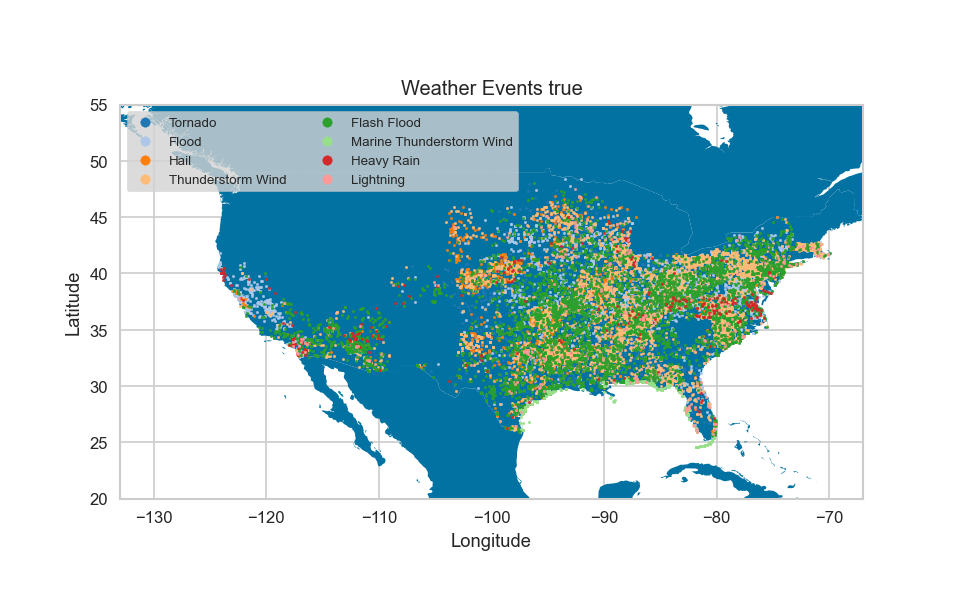

In [53]:
display(plt.gcf())

***
# Local Clustering of Prediction Results
- Visualization of correctly and falsly predicted samples as binary data
- Calcualte Moran's I to check for general clustering of the prediction results
- Calculate Local Indicators of Spatial Association (LISA) to check for local clustering
***

In [37]:
# New attribute 'EQUAL'
points_classified['EQUAL'] = 0

#'EQUAL' = 1 where 'TRUE' and 'PREDICTED' are equal
points_classified.loc[points_classified['TRUE'] == points_classified['PREDICTED'], 'EQUAL'] = 1

<IPython.core.display.Javascript object>


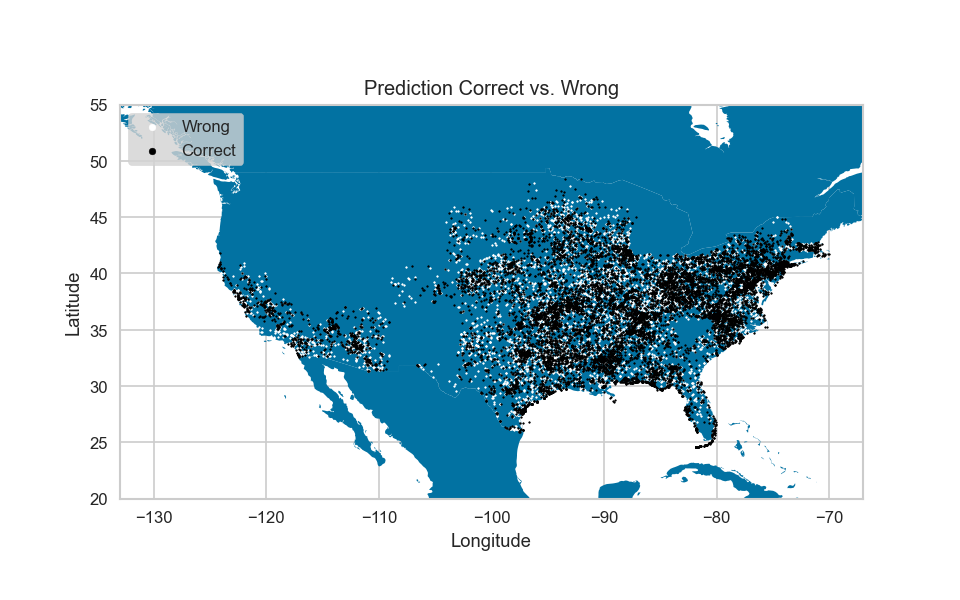

In [38]:
# Create a copy of points_classified
points_classified_plot = points_classified.copy()

# Set the color based on the 'EQUAL' attribute
points_classified_plot['COLOR'] = points_classified_plot['EQUAL'].map({0: 'white', 1: 'black'})

fig, ax = plt.subplots(figsize=(8,5))

# Plot the points with labels
basemap.plot(ax=ax)
points_classified_plot[points_classified_plot['EQUAL'] == 0].plot(ax=ax, marker='o', color='white', label='Wrong', markersize=1)
points_classified_plot[points_classified_plot['EQUAL'] == 1].plot(ax=ax, marker='o', color='black', label='Correct', markersize=1)

ax.set_xlim(-133, -67)
ax.set_ylim(20, 55)

legend = ax.legend(loc='upper left', markerscale=4, frameon=True, facecolor='lightgrey')
plt.title('Prediction Correct vs. Wrong')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

<IPython.core.display.Javascript object>


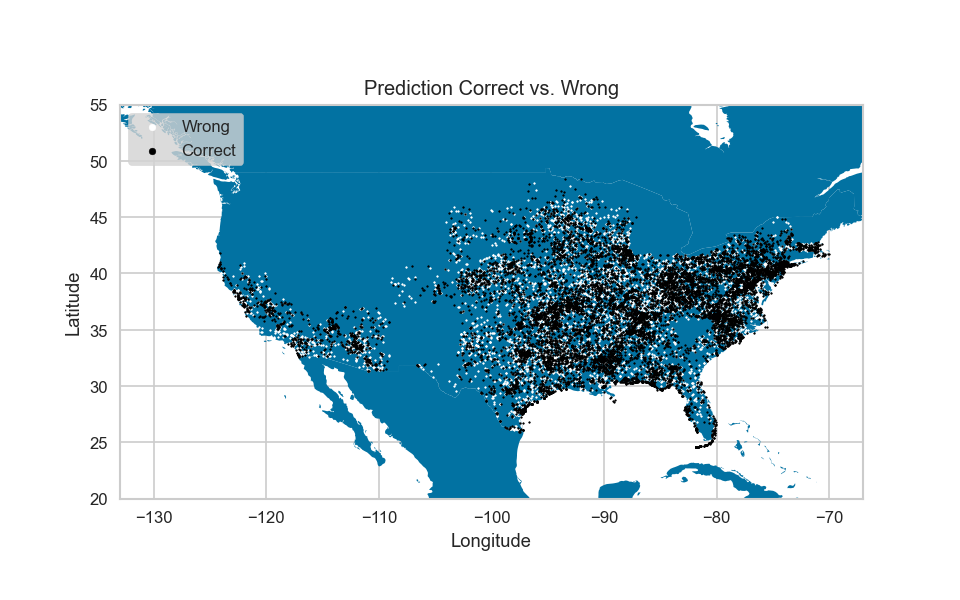

In [39]:
display(plt.gcf())

In [40]:
points_classified_2=points_classified.drop('PREDICTED', axis=1)
points_classified_2=points_classified_2.drop('TRUE', axis=1)

points_classified_2['X'] = points_classified_2.geometry.x
points_classified_2['Y'] = points_classified_2.geometry.y
points_classified_2.head()
points_classified_2.drop('geometry',axis=1)


EQUAL         X        Y
0          0  -89.0096  40.0136
1          1  -85.9175  32.3907
2          1  -86.5506  32.5841
3          1 -122.5393  38.0701
4          1 -122.8475  38.4986
...      ...       ...      ...
19539      1  -94.7447  33.7678
19540      1  -94.7413  33.6941
19541      1  -93.7007  32.0455
19542      1  -93.4398  32.2291
19543      1  -93.5876  32.5548

[19544 rows x 3 columns]

Creating spatial weights matrix using K-Nearest-Neighbors method to calculate Moran's I. This matrix weights the spatial proximity between the observed samples.

In [41]:
data = points_classified_2[['X', 'Y']]
#Spatial weights matrix
w = lps.weights.KNN(data, k=2)
#Calcualte Moran's I
moran = Moran(points_classified_2['EQUAL'], w)
moran_i = moran.I
print("Moran's I:", moran_i)

Moran's I: 0.11669192777084829


Moran's I of 0.16 shows light clustering of the prediction results (Correct and False) across the whole study area.

***
## Local Indicators of Spatial Association (LISA)
- (Anselin, 1995)
- Calculates Local Moran's I for each sample individually
- Calculates p-value (statistical significance) for each point (small p-value --> high significance)
- Forms cluster based on Local Moran's I and p-value (1: high-high, 2: low-low, 3: high-low, 4: low-high)
***

In [42]:
lisa = esda.Moran_Local(points_classified_2['EQUAL'], w)
#Local Moran's I values
local_moran_i = lisa.Is
#p-values associated with local Moran's I values
p_values = lisa.p_sim
# Get clusters
clusters = lisa.q
points_classified_2['LISA']=clusters

In [43]:
for i in range(len(points_classified_2)):
   print(f"Feature {i+1}: Moran's I = {local_moran_i[i]:.4f}, p-value = {p_values[i]:.4f}, Cluster = {clusters[i]}")


Feature 1: Moran's I = 1.4574, p-value = 0.1570, Cluster = 3
Feature 2: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 3: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 4: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 5: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 6: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 7: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 8: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 9: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 10: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 11: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 12: Moran's I = -0.9999, p-value = 0.1570, Cluster = 4
Feature 13: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 14: Moran's I = -0.1569, p-value = 0.3610, Cluster = 4
Feature 15: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 16: Moran's I = 0.6861, p-value = 0.3610, Cluster = 1
Feature 17

Feature 19365: Moran's I = -0.1569, p-value = 0.3630, Cluster = 4
Feature 19366: Moran's I = 1.4574, p-value = 0.1650, Cluster = 3
Feature 19367: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19368: Moran's I = -0.9999, p-value = 0.3630, Cluster = 2
Feature 19369: Moran's I = -0.1569, p-value = 0.3630, Cluster = 4
Feature 19370: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19371: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19372: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19373: Moran's I = -0.1569, p-value = 0.3630, Cluster = 4
Feature 19374: Moran's I = -0.1569, p-value = 0.3630, Cluster = 4
Feature 19375: Moran's I = -0.1569, p-value = 0.3630, Cluster = 4
Feature 19376: Moran's I = 0.2287, p-value = 0.3630, Cluster = 3
Feature 19377: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19378: Moran's I = 0.6861, p-value = 0.3630, Cluster = 1
Feature 19379: Moran's I = -0.9999, p-value = 0.3630, Cluster = 2
Feature 19380: Mor

<IPython.core.display.Javascript object>


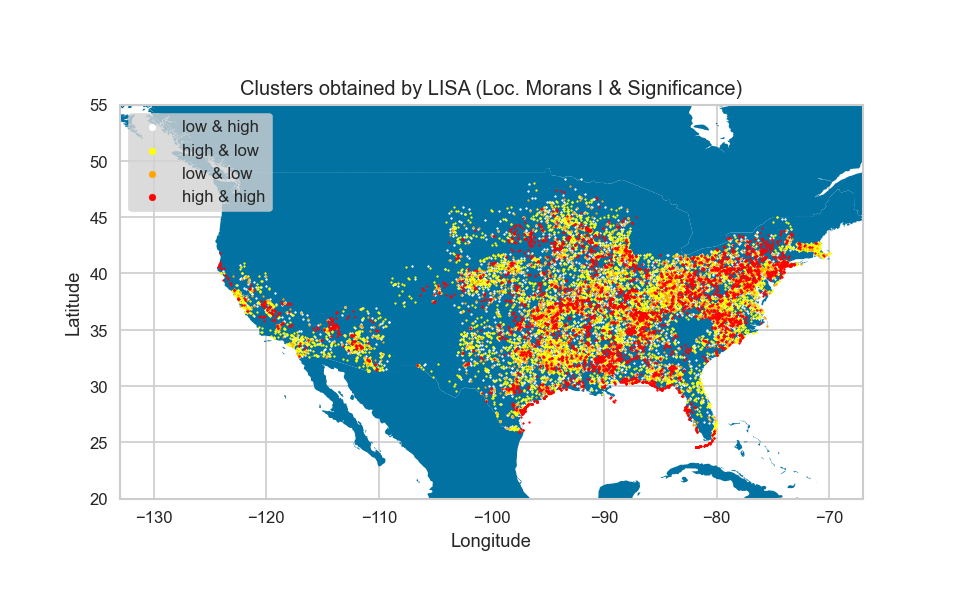

In [44]:
# Define the custom colors for each class
class_colors = ['white', 'yellow', 'orange', 'red']
classes = sorted(points_classified_2['LISA'].unique(), reverse=True)

fig, ax = plt.subplots(figsize=(8,5))
basemap.plot(ax=ax)

# Iterate over each class and plot the corresponding points with the custom color
for class_name, color in zip(classes, class_colors):
    class_data = points_classified_2[points_classified_2['LISA'] == class_name]
    class_data.plot(ax=ax, marker='o', color=color, markersize=1, label=class_name, )

ax.set_xlim(-133, -67)
ax.set_ylim(20, 55)

legend = ax.legend(loc='upper left', markerscale=4, frameon=True, facecolor='lightgrey')

#modify labels
legend.get_texts()[0].set_text('low & high')
legend.get_texts()[1].set_text('high & low')
legend.get_texts()[2].set_text('low & low')
legend.get_texts()[3].set_text('high & high')

plt.title('Clusters obtained by LISA (Loc. Morans I & Significance)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

<IPython.core.display.Javascript object>


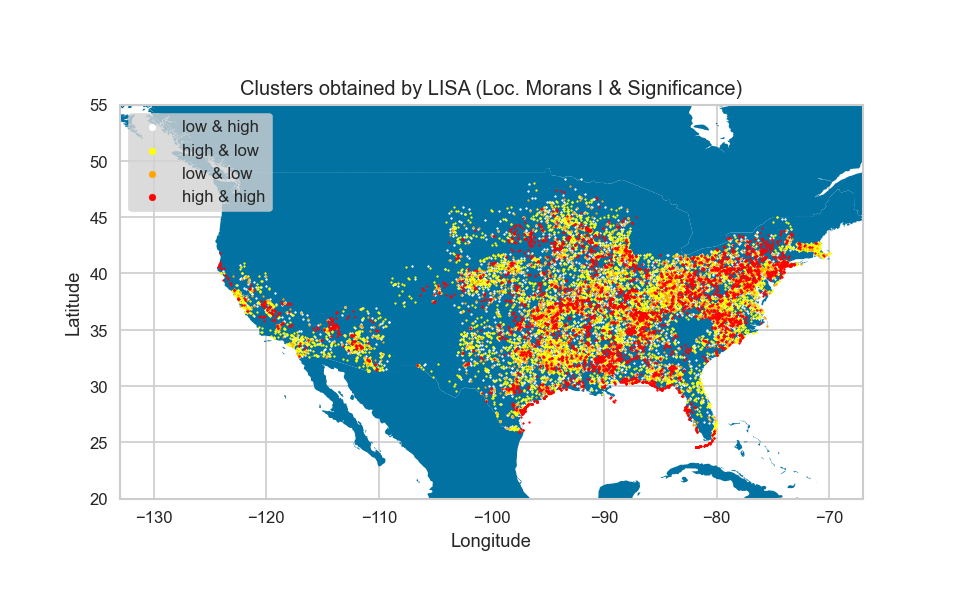

In [45]:
display(plt.gcf())
#Loc. Moran's I-Significance:      1: high-high, 2: low-low, 3: high-low, 4: low-high

Points colored red (Cluster 1) are locations where correctly classified events are clustered so in areas where there is a high density of red points the model performs well. In this case we have a high autocorrelation of correctly predicted values. This is well visible at the coastline of the gulf of mexico where the marine thunderstorm winds are predicted with a high Accuracy (see confusion matrix). On the other hand yellow points are observations with a high local Moran's I but bad significance so in these areas we have a high density of wrongly predicted samples. White and orange observations are samples where Moran's I is low so we rather have dispersion of points with the same model result (correct/wrong). 

***
## Conclusion I
- RFC worked with a classification accuracy of 0.59
- Most important attributes were: duration of event, location of event and damage to property 
- Accuracy would probably be better when:
    - Input attributes would have a broader std. deviation (see histograms)
    - Higher minimum sample size per labled class and location value so train data can be larger 
***

***
## Conclusion II
- Correctly classified observations do cluster depending on the type of Event that occures in that area. So the performance of the model strongly varies depending on the type of event. E.g. cluster of correct classifications at coast line (marine thunderstorms) but no clustering and bad performance where for example thunderstorm winds commonly occur (central USA)
***

***
### Sources I
- Anselin L. 1995. Local indicators of spatial association—LISA. Geographical Analysis 27:93-115
- Kossin, J.P.; Knapp, K.R.; Olander, T.L.; Velden, C.S. Global increase in major tropical cyclone exceedance probability over the past four decades. Proc. Natl. Acad. Sci. USA 2020, 117, 11975–11980.
- Ostroff, A.C., Muhlfeld, C.C., Lambert, P.M., Booth, N.L., Carter, S.L., Stoker, J.M., and Focazio, M.J., 2017, USGS integrated drought science: U.S. Geological Survey Circular 1430, 24 p., https://doi.org/10.3133/cir1430.
***

***
### Sources II
- Parry, ML & Canziani, O & Palutikof, JP & van der Linden, Paul & Hanson, CE. (2007). Climate Change 2007: Impacts, Adaptation  and Vulnerability.
-https://www.ncei.noaa.gov/access/billions/ 
***